<a href="https://colab.research.google.com/github/enoch20142009/stock-market/blob/main/notebooks/financial_news_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

# Import Packages

In [3]:
# IMPORTS
import numpy as np
import pandas as pd
import requests
from io import StringIO
import json


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

import sqlite3

# Functions

In [ ]:
def log_audit(issue_type, description, record_count, file='data/audit_log.csv'):
    with open(file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([datetime.now(), issue_type, description, record_count])

# Ingest Datasets

In [4]:
# Extract AAPL, MSFT, TSLA price information from yfinance
tickers = ['AAPL', 'MSFT', 'TSLA']
stock_df = yf.download(tickers, start="2023-01-01", end="2023-06-01")
stock_df = stock_df.stack(level=1).reset_index().rename(columns={"level_1": "ticker"})

/tmp/ipython-input-4-3503983122.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(tickers, start="2023-01-01", end="2023-06-01")
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-4-3503983122.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stock_df = stock_df.stack(level=1).reset_index().rename(columns={"level_1": "ticker"})


Price,Date,Ticker,Close,High,Low,Open,Volume
0,2023-01-03,AAPL,123.470612,129.226052,122.582119,128.613985,112117500
1,2023-01-03,MSFT,234.808975,240.856103,232.672380,238.239276,25740000
2,2023-01-03,TSLA,108.099998,118.800003,104.639999,118.470001,231402800
3,2023-01-04,AAPL,124.744118,127.014709,123.480487,125.267339,89113600
4,2023-01-04,MSFT,224.537674,228.232587,221.460205,227.654340,50623400


In [37]:
stock_df.head()

Price,Date,Ticker,Close,High,Low,Open,Volume
0,2023-01-03,AAPL,123.470612,129.226052,122.582119,128.613985,112117500
1,2023-01-03,MSFT,234.808975,240.856103,232.672380,238.239276,25740000
2,2023-01-03,TSLA,108.099998,118.800003,104.639999,118.470001,231402800
3,2023-01-04,AAPL,124.744118,127.014709,123.480487,125.267339,89113600
4,2023-01-04,MSFT,224.537674,228.232587,221.460205,227.654340,50623400


In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    309 non-null    datetime64[ns]
 1   Ticker  309 non-null    object        
 2   Close   309 non-null    float64       
 3   High    309 non-null    float64       
 4   Low     309 non-null    float64       
 5   Open    309 non-null    float64       
 6   Volume  309 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 17.0+ KB


In [31]:
# Read in financial news dataset
from pandas import json_normalize

with open("polygon_news_sample.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Convert nested JSON news dataset into structured tabular format
exploded_df = df.explode('insights').reset_index(drop=True)
exploded_df = json_normalize(exploded_df['insights'])
news_df = pd.concat([df.drop(columns=['insights']), exploded_df], axis=1)
news_df

# Only keep useful columns
news_df = news_df[['published_utc', 'description', 'title', 'ticker', 'sentiment', 'sentiment_reasoning']]
news_df.isnull().any()

# Filter to only 'AAPL', 'MSFT', 'TSLA'
tickers = ['AAPL', 'MSFT', 'TSLA']
filter = news_df['ticker'].isin(tickers)
news_df = news_df[filter]

,published_utc,description,title,ticker,sentiment,sentiment_reasoning
109,2023-10-31T15:39:00Z,Arch Capital Group Ltd. reported strong third-...,Arch Capital (ACGL) Q3 Earnings Top on Solid U...,TSLA,positive,Tesla's stock has rebounded 99% year-to-date a...
110,2023-06-22T13:00:13Z,Cisco Systems (CSCO) has been a trending stock...,"Here is What to Know Beyond Why Cisco Systems,...",TSLA,positive,The article expects Tesla's Investor Day event...
144,2023-11-22T14:38:00Z,The trucking industry is benefiting from impro...,The Zacks Analyst Blog Highlights Knight-Swift...,TSLA,positive,Tesla is the largest producer of electric vehi...
145,2023-12-22T11:00:00Z,The article discusses the latest research repo...,"The Zacks Analyst Blog Highlights Alphabet, Co...",MSFT,positive,Microsoft is included in the 'Magnificent 7' t...
168,2023-02-24T14:55:09Z,Pegasystems (PEGA) has formed a hammer chart p...,"Pegasystems (PEGA) Could Find a Support Soon, ...",AAPL,positive,Apple is praised for its effective stock repur...


In [35]:
news_df.head()

,published_utc,description,title,ticker,sentiment,sentiment_reasoning,Date
109,2023-10-31 15:39:00+00:00,Arch Capital Group Ltd. reported strong third-...,Arch Capital (ACGL) Q3 Earnings Top on Solid U...,TSLA,positive,Tesla's stock has rebounded 99% year-to-date a...,2023-10-31
110,2023-06-22 13:00:13+00:00,Cisco Systems (CSCO) has been a trending stock...,"Here is What to Know Beyond Why Cisco Systems,...",TSLA,positive,The article expects Tesla's Investor Day event...,2023-06-22
144,2023-11-22 14:38:00+00:00,The trucking industry is benefiting from impro...,The Zacks Analyst Blog Highlights Knight-Swift...,TSLA,positive,Tesla is the largest producer of electric vehi...,2023-11-22
145,2023-12-22 11:00:00+00:00,The article discusses the latest research repo...,"The Zacks Analyst Blog Highlights Alphabet, Co...",MSFT,positive,Microsoft is included in the 'Magnificent 7' t...,2023-12-22
168,2023-02-24 14:55:09+00:00,Pegasystems (PEGA) has formed a hammer chart p...,"Pegasystems (PEGA) Could Find a Support Soon, ...",AAPL,positive,Apple is praised for its effective stock repur...,2023-02-24


In [32]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 109 to 13368
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   published_utc        129 non-null    object
 1   description          129 non-null    object
 2   title                129 non-null    object
 3   ticker               317 non-null    object
 4   sentiment            317 non-null    object
 5   sentiment_reasoning  317 non-null    object
dtypes: object(6)
memory usage: 25.4+ KB


# Data Hygiene work

In [ ]:
# Ensure no missing values/invalid values and set up audit trail to track for deleted rows, remove neutral sentiment
news_df = news_df.dropna()
news_df = news_df[news_df['sentiment'] != 'neutral']
# Need to record

# Ensure no invalid values (Validation check)
stock_df = stock_df.dropna()
filter = (stock_df['Close'] > 0) & (stock_df['High'] > 0) & (stock_df['Low'] > 0) & (stock_df['Open'	] > 0)& (stock_df['Volume'] > 0)
stock_df = stock_df[filter]
# Need to record

In [54]:
# Ensure the consistency of date format in stock_df
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Convert date format on news_df_final
news_df['published_utc'] = pd.to_datetime(news_df['published_utc'])
news_df['Date'] = news_df['published_utc'].dt.date
news_df.drop('published_utc', axis=1, inplace=True)
news_df['Date'] = pd.to_datetime(news_df['Date'])
# Need to record (added column)


/tmp/ipython-input-54-3707434721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['published_utc'] = pd.to_datetime(news_df['published_utc'])
/tmp/ipython-input-54-3707434721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['Date'] = news_df['published_utc'].dt.date
/tmp/ipython-input-54-3707434721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [55]:
# Drop duplicate just in case of multiple entries and only keep the first news for the day for simplicity
stock_df = stock_df.drop_duplicates(subset=['Date', 'Ticker'])
# Need to record

news_df = news_df.drop_duplicates(subset=['Date', 'ticker'])
# Need to record


# Dataset Integration

In [65]:
# Merge the two dataset
merged_df = pd.merge(news_df, stock_df, how='inner', left_on=['ticker', 'Date'], right_on=['Ticker', 'Date'])
# Need to record

merged_df.drop('ticker', axis=1, inplace=True)
merged_df

# Need to record

# Build a check that ensures the merged_df nrow = news_df nrow




,description,title,sentiment,sentiment_reasoning,Date,Ticker,Close,High,Low,Open,Volume
0,Pegasystems (PEGA) has formed a hammer chart p...,"Pegasystems (PEGA) Could Find a Support Soon, ...",positive,Apple is praised for its effective stock repur...,2023-02-24,AAPL,145.055038,145.529620,144.076201,145.450520,55469600
1,Orange is holding its annual general meeting o...,Orange: Assemblée générale du 23 mai 2023 - Mo...,positive,Berkshire invested in Apple when it was tradin...,2023-04-21,AAPL,163.158478,164.572339,162.634458,163.188138,58337300
2,Analyst downgrades SiTime due to lack of visib...,SiTime Downgraded: Lack Of Visibility Of Oscil...,neutral,The article does not provide a specific sentim...,2023-05-04,MSFT,300.077789,302.386766,298.102873,300.893285,22519900
3,ProMIS Neurosciences presented preclinical dat...,ProMIS Neurosciences Presents Preclinical Data...,positive,Microsoft is described as a legend of Wall Str...,2023-04-24,MSFT,276.850494,279.974997,273.853757,277.164915,26611000
4,"U.S. Bancorp is a strong dividend play, with a...",U.S. Bancorp (USB) is a Top Dividend Stock Rig...,neutral,Tesla is mentioned as a better-established bus...,2023-01-26,TSLA,160.270004,161.419998,154.759995,159.970001,234815100
5,"Hologic, a medical device maker, has seen its ...","Hologic, Inc. (HOLX) Is a Trending Stock: Fact...",neutral,Microsoft's GitHub was mentioned as a competit...,2023-02-17,MSFT,253.554413,255.548969,251.530382,254.861209,30000100
6,Osisko Development Corp. is seeking approval t...,Osisko Development Announces Proposed Reductio...,positive,Apple is the world's third-largest video game ...,2023-03-14,AAPL,150.868698,151.669558,148.406796,149.573478,73695900
7,"Insiders have been selling shares in Crocs, Dr...","Crocs, Lamb Weston And These 3 Stocks Insiders...",neutral,The article mentions Microsoft as getting atte...,2023-01-06,MSFT,220.450668,221.264141,214.981803,218.559110,43613600
8,The article discusses how Amazon and Nvidia co...,These 2 High-Growth Stocks Could Power the Bul...,positive,Tesla's stock was up around 2.7% during the da...,2023-03-20,TSLA,183.250000,186.440002,176.350006,178.080002,129684400
9,Crocs and Dollar General are two stocks that c...,2 Growth Stocks That Could Soar in 2023,positive,Datadog is extending its collaboration with Mi...,2023-01-11,MSFT,231.074829,231.251237,226.507626,226.684034,28669300


In [66]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   description          43 non-null     object        
 1   title                43 non-null     object        
 2   sentiment            43 non-null     object        
 3   sentiment_reasoning  43 non-null     object        
 4   Date                 43 non-null     datetime64[ns]
 5   Ticker               43 non-null     object        
 6   Close                43 non-null     float64       
 7   High                 43 non-null     float64       
 8   Low                  43 non-null     float64       
 9   Open                 43 non-null     float64       
 10  Volume               43 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 3.8+ KB


In [67]:
# Add daily difference column
merged_df['daily_diff'] = merged_df['Close'] - merged_df['Open']

# Set up a flag to analysis whether the

# Export the merged dataset into csv
merged_df

,description,title,sentiment,sentiment_reasoning,Date,Ticker,Close,High,Low,Open,Volume,daily_diff
0,Pegasystems (PEGA) has formed a hammer chart p...,"Pegasystems (PEGA) Could Find a Support Soon, ...",positive,Apple is praised for its effective stock repur...,2023-02-24,AAPL,145.055038,145.529620,144.076201,145.450520,55469600,-0.395482
1,Orange is holding its annual general meeting o...,Orange: Assemblée générale du 23 mai 2023 - Mo...,positive,Berkshire invested in Apple when it was tradin...,2023-04-21,AAPL,163.158478,164.572339,162.634458,163.188138,58337300,-0.029660
2,Analyst downgrades SiTime due to lack of visib...,SiTime Downgraded: Lack Of Visibility Of Oscil...,neutral,The article does not provide a specific sentim...,2023-05-04,MSFT,300.077789,302.386766,298.102873,300.893285,22519900,-0.815496
3,ProMIS Neurosciences presented preclinical dat...,ProMIS Neurosciences Presents Preclinical Data...,positive,Microsoft is described as a legend of Wall Str...,2023-04-24,MSFT,276.850494,279.974997,273.853757,277.164915,26611000,-0.314420
4,"U.S. Bancorp is a strong dividend play, with a...",U.S. Bancorp (USB) is a Top Dividend Stock Rig...,neutral,Tesla is mentioned as a better-established bus...,2023-01-26,TSLA,160.270004,161.419998,154.759995,159.970001,234815100,0.300003
5,"Hologic, a medical device maker, has seen its ...","Hologic, Inc. (HOLX) Is a Trending Stock: Fact...",neutral,Microsoft's GitHub was mentioned as a competit...,2023-02-17,MSFT,253.554413,255.548969,251.530382,254.861209,30000100,-1.306796
6,Osisko Development Corp. is seeking approval t...,Osisko Development Announces Proposed Reductio...,positive,Apple is the world's third-largest video game ...,2023-03-14,AAPL,150.868698,151.669558,148.406796,149.573478,73695900,1.295220
7,"Insiders have been selling shares in Crocs, Dr...","Crocs, Lamb Weston And These 3 Stocks Insiders...",neutral,The article mentions Microsoft as getting atte...,2023-01-06,MSFT,220.450668,221.264141,214.981803,218.559110,43613600,1.891558
8,The article discusses how Amazon and Nvidia co...,These 2 High-Growth Stocks Could Power the Bul...,positive,Tesla's stock was up around 2.7% during the da...,2023-03-20,TSLA,183.250000,186.440002,176.350006,178.080002,129684400,5.169998
9,Crocs and Dollar General are two stocks that c...,2 Growth Stocks That Could Soar in 2023,positive,Datadog is extending its collaboration with Mi...,2023-01-11,MSFT,231.074829,231.251237,226.507626,226.684034,28669300,4.390795


# Result Analysis

In [68]:
# Sentiment vs Price Change Direction

# Subsets
positive = merged_df[merged_df['sentiment'] == 'positive']
negative = merged_df[merged_df['sentiment'] == 'negative']

# Hit Rates (%)
pos_hit_rate = (positive['daily_diff'] > 0).mean() * 100
neg_hit_rate = (negative['daily_diff'] < 0).mean() * 100

print(f"Positive Sentiment Hit Rate: {pos_hit_rate:.2f}%")
print(f"Negative Sentiment Hit Rate: {neg_hit_rate:.2f}%")


Positive Sentiment Hit Rate: 57.58%
Negative Sentiment Hit Rate: 100.00%


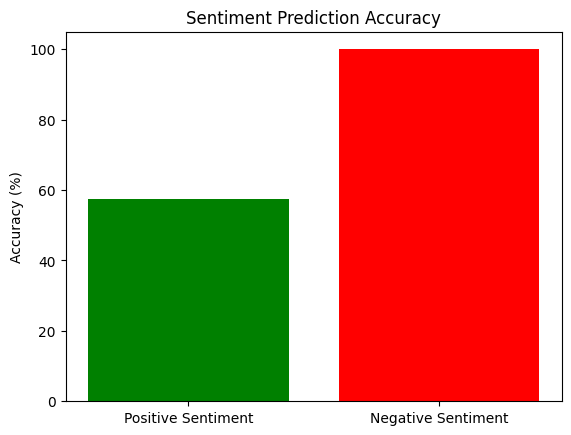

In [69]:
plt.bar(['Positive Sentiment', 'Negative Sentiment'], [pos_hit_rate, neg_hit_rate], color=['green', 'red'])
plt.ylabel("Accuracy (%)")
plt.title("Sentiment Prediction Accuracy")
plt.show()

In [70]:
# Average Return by Sentiment
avg_returns = merged_df.groupby('sentiment')['daily_diff'].mean()
print(avg_returns)

sentiment
negative   -0.170006
neutral    -1.440270
positive    0.504225
Name: daily_diff, dtype: float64


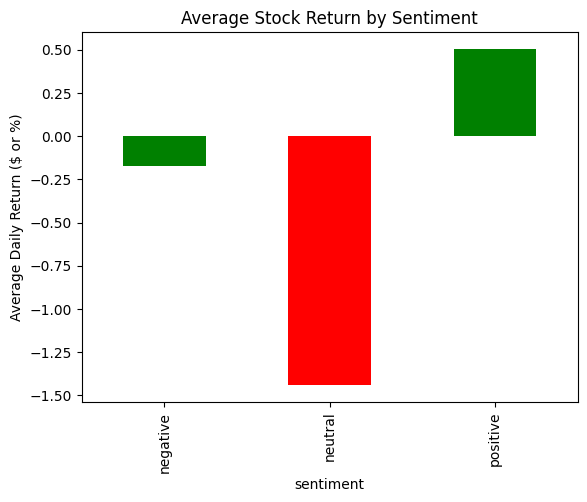

In [71]:
avg_returns.plot(kind='bar', color=['green', 'red'])
plt.ylabel("Average Daily Return ($ or %)")
plt.title("Average Stock Return by Sentiment")
plt.show()


In [75]:
# correlation with sentiment
# Assuming 'sentiment_numeric' is prepared: positive → 1, negative → -1
merged_df['sentiment_numeric'] = merged_df['sentiment'].map({'positive': 1, 'negative': -1})

correlation = merged_df[['sentiment_numeric', 'daily_diff']].corr().iloc[0,1]
print(f"Correlation between Sentiment and Price Change: {correlation:.2f}")


Correlation between Sentiment and Price Change: 0.04


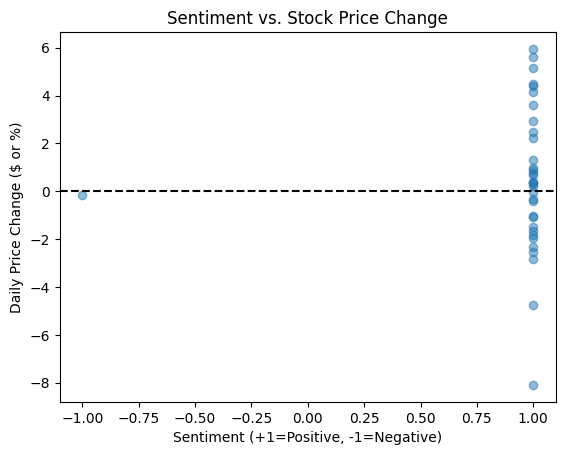

In [76]:
plt.scatter(merged_df['sentiment_numeric'], merged_df['daily_diff'], alpha=0.5)
plt.xlabel("Sentiment (+1=Positive, -1=Negative)")
plt.ylabel("Daily Price Change ($ or %)")
plt.title("Sentiment vs. Stock Price Change")
plt.axhline(0, color='black', linestyle='--')
plt.show()


# Steramlit